In [48]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'DB_and_Azure'))
import sql_db_functions as SQLf

### get data from server

In [49]:
conn, cursor = SQLf.sql_db_functions.connect_sql()

In [50]:
query = "SELECT product_characteristics.id, Brand_id , Detail, Summary, Brand FROM product_characteristics INNER JOIN Products ON product_characteristics.Brand_id = Products.Brand_Prod_id ;"
cursor.execute(query)

# Fetch the rows
rows = cursor.fetchall()
rows[0]

(1,
 1,
 '*Type: Shirt  \n*Fit: Regular fit  \n*Sleeve style: Long sleeve  \n*Neckline: Not Applicable  \n*Material: Silk  \n*Formality: Formal  \n*Season: Spring, Summer, Autumn  \n*Colors: Pink 100%  \n*Texture: Smooth  \n*Transparency: Opaque  \n*Details and Embellishments: Buttons  \n*Shape: Fitted  \n*Length: Hip-length  \n*Collar Style: Button-down  \n*Sleeve Style: Long  \n*Patterns: Geometric  \n*Patterns placement: Overall  \n*Fluidity of fabric: High  \n*Fabric weight: Light  \n*Pocket Presence: No  \n*Pocket placement: Not applicable  \n*Pocket size: Not applicable  \n*Breathability: High  \n*Occasion Suitability: Formal, Business Casual  \n*Lapel: Not applicable',
 'The Gucci silk shirt, featuring the GG Shadow monogram, is a sophisticated piece designed with meticulous attention to detail. The shirt has a relaxed fit and long sleeves with buttoned cuffs, making it suitable for both formal and semi-formal occasions. It boasts a classic collar and a button-down front, enhanc

In [51]:
conn, cursor = SQLf.sql_db_functions.connect_sql()

In [52]:
query = "SELECT Brand_id, base64 FROM product_img ;"
cursor.execute(query)

# Fetch the rows
rows_img = cursor.fetchall()
#rows_img

In [53]:
len(rows_img)

632

In [54]:
SQLf.sql_db_functions.close_connection_db(conn=conn,cursor=cursor)

### organize data

In [55]:
import pandas as pd

In [56]:
df = pd.DataFrame(rows ,columns= ['Id','prod_id','descripcion', 'Summary','Brand'])

In [57]:
df.head()

,Id,prod_id,descripcion,Summary,Brand
0,1,1,*Type: Shirt \n*Fit: Regular fit \n*Sleeve s...,"The Gucci silk shirt, featuring the GG Shadow ...",Gucci
1,2,2,*Type: Shirt \n*Fit: Regular fit \n*Sleeve s...,The Gucci shirt in the images is a sophisticat...,Gucci
2,3,3,"*Type: Top, Shirt \n*Fit: Regular fit \n*Sle...",The top featured in the images is a Gucci crop...,Gucci
3,4,4,*Type: Shirt \n*Fit: Regular fit \n*Sleeve s...,The Gucci silk shirt features a vibrant and so...,Gucci
4,5,5,*Type: Shirt\n*Fit: Regular fit\n*Sleeve style...,The Gucci Oxford GG Supreme shirt is a sophist...,Gucci


In [58]:
df['descripcion'] = df['descripcion'].str.replace('\n*', ' / ')
df['descripcion'] = df['descripcion'].str.replace(r'\s+', ' ')
df['descripcion'] = df['descripcion'].str.replace('*', ' ')

df.head(5)

,Id,prod_id,descripcion,Summary,Brand
0,1,1,Type: Shirt / Fit: Regular fit / Sleeve s...,"The Gucci silk shirt, featuring the GG Shadow ...",Gucci
1,2,2,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci shirt in the images is a sophisticat...,Gucci
2,3,3,"Type: Top, Shirt / Fit: Regular fit / Sle...",The top featured in the images is a Gucci crop...,Gucci
3,4,4,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci silk shirt features a vibrant and so...,Gucci
4,5,5,Type: Shirt / Fit: Regular fit / Sleeve style...,The Gucci Oxford GG Supreme shirt is a sophist...,Gucci


In [59]:
df['Complete_description'] = df['Summary'] + ' /' + "Brand: " + df['Brand'] + " /" + df['descripcion']
df.head()

,Id,prod_id,descripcion,Summary,Brand,Complete_description
0,1,1,Type: Shirt / Fit: Regular fit / Sleeve s...,"The Gucci silk shirt, featuring the GG Shadow ...",Gucci,"The Gucci silk shirt, featuring the GG Shadow ..."
1,2,2,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci shirt in the images is a sophisticat...,Gucci,The Gucci shirt in the images is a sophisticat...
2,3,3,"Type: Top, Shirt / Fit: Regular fit / Sle...",The top featured in the images is a Gucci crop...,Gucci,The top featured in the images is a Gucci crop...
3,4,4,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci silk shirt features a vibrant and so...,Gucci,The Gucci silk shirt features a vibrant and so...
4,5,5,Type: Shirt / Fit: Regular fit / Sleeve style...,The Gucci Oxford GG Supreme shirt is a sophist...,Gucci,The Gucci Oxford GG Supreme shirt is a sophist...


In [60]:
documents = df['Complete_description'].tolist()
id = df['Id'].astype('str').tolist()
metadata = [{"source": id} for id in df['Id'].astype('str').tolist()]

In [61]:
df_image = pd.DataFrame(rows_img, columns=['prod_id', 'base64'])

In [62]:
df_image.head(2)

,prod_id,base64
0,1,"data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQ..."
1,1,"data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQ..."


In [63]:
df_image.shape

(632, 2)

In [64]:
del rows, rows_img

### Get images 

In [65]:
import base64
from io import BytesIO
from PIL import Image

In [66]:
def base64_to_image(base64_string):
    # Remove the data URI prefix if present
    if "data:image" in base64_string:
        base64_string = base64_string.split(",")[1]

    # Decode the Base64 string into bytes
    image_bytes = base64.b64decode(base64_string)
    return image_bytes

In [67]:
def create_image_from_bytes(image_bytes):
    # Create a BytesIO object to handle the image data
    image_stream = BytesIO(image_bytes)

    # Open the image using Pillow (PIL)
    image = Image.open(image_stream)
    return image

In [68]:
def resize_image(image, new_width):
    # Open the image

    # Calculate the new height while maintaining the aspect ratio
    original_width, original_height = image.size
    aspect_ratio = original_height / original_width
    new_height = int(new_width * aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    return resized_image


In [69]:
df_image.iloc[200].base64

'data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALuAlgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1uloooAKXFJS0AFFFLigBKWiigAooooAKKKXFACUtGKKACiiigAooooAKXFFFACUUtFABRRRQAUUUtACUUtFACUUtFACUUtFABiiilxQAlLRRQAUUUUAFFFFABRRRQAUlLRQAlFLRQAlFLRQ

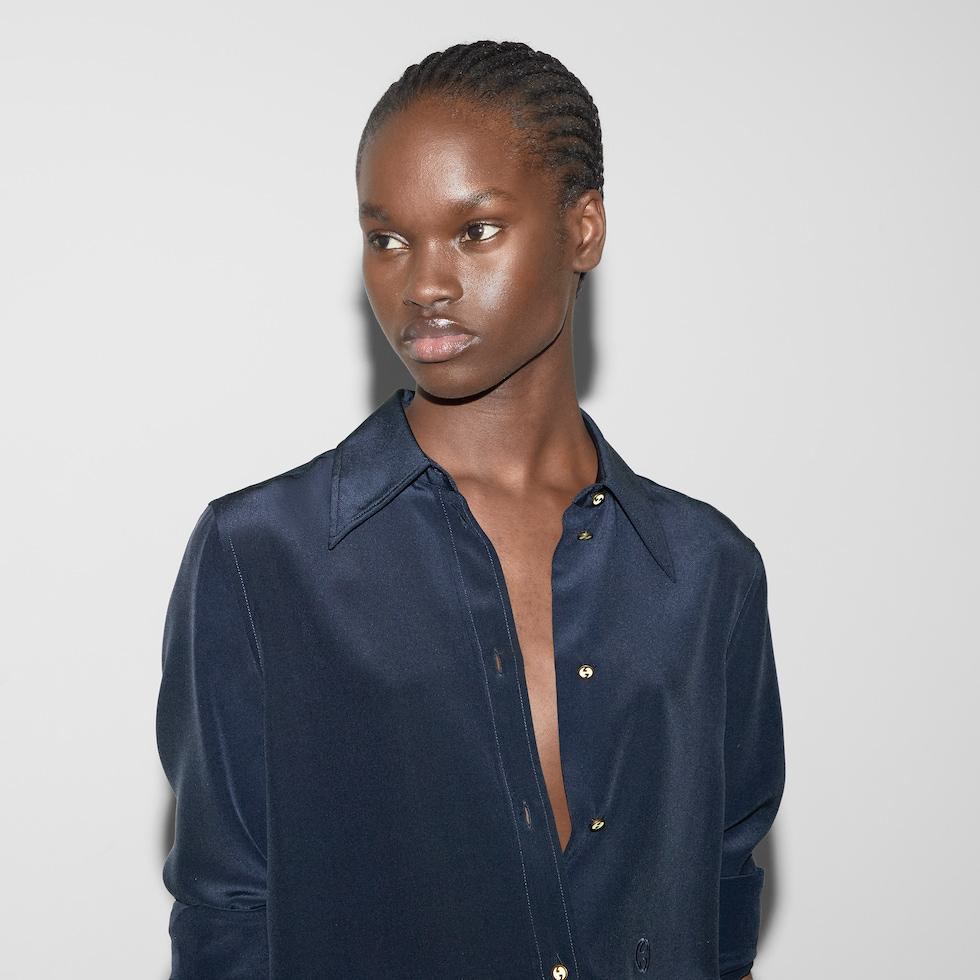

In [70]:
image_bytes = base64_to_image(df_image.iloc[42].base64)
create_image_from_bytes(image_bytes=image_bytes)

### Testing embeddings

In [71]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [72]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

In [73]:
embedding_function = SentenceTransformerEmbeddings(model_name='all-mpnet-base-v2')

### organized text 

In [74]:
df = pd.merge(
            df,
            df_image.groupby('prod_id')['base64'].apply(list).reset_index(),
            on='prod_id'
        )

In [75]:
df.prod_id = df.prod_id.astype(int)
df.sort_values('prod_id',ascending=True,inplace=True)
df.reset_index(drop=True, inplace= True)
df.prod_id = df.prod_id.astype('string')
df.head(5)

,Id,prod_id,descripcion,Summary,Brand,Complete_description,base64
0,1,1,Type: Shirt / Fit: Regular fit / Sleeve s...,"The Gucci silk shirt, featuring the GG Shadow ...",Gucci,"The Gucci silk shirt, featuring the GG Shadow ...","[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,2,2,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci shirt in the images is a sophisticat...,Gucci,The Gucci shirt in the images is a sophisticat...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
2,3,3,"Type: Top, Shirt / Fit: Regular fit / Sle...",The top featured in the images is a Gucci crop...,Gucci,The top featured in the images is a Gucci crop...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
3,4,4,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci silk shirt features a vibrant and so...,Gucci,The Gucci silk shirt features a vibrant and so...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
4,5,5,Type: Shirt / Fit: Regular fit / Sleeve style...,The Gucci Oxford GG Supreme shirt is a sophist...,Gucci,The Gucci Oxford GG Supreme shirt is a sophist...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


### chunks

In [76]:
df = df[['prod_id', 'Summary','Brand','base64']]._append(df[['prod_id', 'descripcion','Brand','base64']].rename(columns = {'descripcion':'Summary'}),ignore_index=True)

In [77]:
df.Brand.unique()

array(['Gucci', 'Prada', 'HM', 'Mango'], dtype=object)

In [78]:
df.head()

,prod_id,Summary,Brand,base64
0,1,"The Gucci silk shirt, featuring the GG Shadow ...",Gucci,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,2,The Gucci shirt in the images is a sophisticat...,Gucci,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
2,3,The top featured in the images is a Gucci crop...,Gucci,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
3,4,The Gucci silk shirt features a vibrant and so...,Gucci,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
4,5,The Gucci Oxford GG Supreme shirt is a sophist...,Gucci,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


In [79]:
persist_directory = '../../../Chromadb/chroma-retail'

In [80]:
store = InMemoryStore()
id_key = 'doc_id'

In [81]:
min(df['base64'].apply(lambda x: len(x)))

1

In [82]:
df[ df['base64'].apply(lambda x: len(x)) == 1 ]

,prod_id,Summary,Brand,base64
124,125,"The shirt is a fluid fabric, straight-cut top ...",Mango,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
278,125,"Type: Shirt / Fit: Straight-cut, NotSlim fit ...",Mango,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


In [83]:
df.iloc[278].base64

['data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAswCAADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2PGKKBRVEhQeaDQPXtQAYozmijpQAtJRQe9ABmg8UDiigBetFJnml70AGKAaKKACij8KKAFopPwpRyaADpRRRQAZo6mgUY560AFHSjpRQAUtJRQAtA60d6OlABR2ozR2oAXmkzR1ooAWkFB

In [87]:
def return_none(x):

    if len(x.base64) == 1: return 'None'

    return x.base64[1]

In [88]:
doc_ids = df.prod_id


texts = [
    Document(
        page_content= df.iloc[i].Summary, 
        metadata={
            id_key:df.iloc[i].prod_id,
            "img_1": df.iloc[i].base64[0],
            "img_2": return_none( df.iloc[i] )  
            }
    )
    for i in df.index
]


In [89]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

In [91]:
vectorstore = Chroma.from_documents(
                documents=texts,
                #ids=doc_ids,
                embedding=embedding_function,
                collection_name='multi_modal_rag',
                #metadatas=metadata,
                persist_directory=persist_directory
            )

In [92]:
vectorstore.similarity_search('HM')[0].page_content

'This long, oversized shirt from Mango is crafted from 100% cotton, providing a breathable and comfortable fit ideal for various seasons. The shirt features a classic button-down front with a traditional collar, adding a touch of formality suitable for both casual and semi-formal occasions. The fabric is lightweight and has a smooth texture, ensuring fluidity and ease of movement. The shirt is predominantly white, a versatile color that complements any wardrobe. It includes long sleeves with buttoned cuffs, enhancing its polished look. The design is simple yet elegant, with no additional embellishments or patterns, making it a timeless piece. The shirt also includes a single chest pocket, adding a functional detail without compromising its sleek appearance.'

In [93]:
from langchain.retrievers import ParentDocumentRetriever

In [94]:
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

In [104]:
retriever.add_documents(texts, ids=None)

In [105]:
retrieved_docs = retriever.invoke("HM")

In [107]:
retrieved_docs

Document(page_content=' Type: Shirt / Fit: Straight fit / Sleeve style: Long sleeve / Neckline: Not applicable / Material: Not specified / Formality: Business Casual / Season: Autumn, Winter / Colors: Black 100% / Texture: Smooth / Transparency: Opaque / Details and Embellishments: Buttons / Shape: Boxy / Length: Hip-length / Collar Style: Button-down / Sleeve Style: Long / Patterns: Not applicable / Patterns placement: Not applicable / Fluidity of fabric: Medium / Fabric weight: Medium / Pocket Presence: No / Pocket placement: Not applicable / Pocket size: Not applicable / Breathability: Medium / Occasion Suitability: Business casual / Lapel: Not applicable', metadata={'doc_id': '88', 'img_1': 'data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAswCAADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQ

### Already loaded !!!

In [ ]:
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
    search_kwargs={"k":5}
)

In [ ]:
docs = retriever.invoke(
    "HM"
)

In [ ]:
docs

In [ ]:
retriever.vectorstore.add_documents(texts)
#retriever.docstore.mset(list(zip(doc_ids, texts)))

In [ ]:
docs = retriever.invoke(
    "HM"
)

In [ ]:
docs

In [ ]:
df.iloc[1].Complete_description

### Talk to Chroma

In [ ]:
from apikey import apikey 
from langchain.chat_models import ChatOpenAI

In [ ]:
os.environ['OPENAI_API_KEY'] = apikey

In [ ]:
turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo'
)

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

### lets set up the system

from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
system_prompt = (
    "You are a Fashion specialist engine to sugest clothing pieces from context. "
    "If you don't know the answer to the question, say that you dont know "
    "answer concise."
    #"Explain why the selected options of the context are the best ones"
    "\n\n"
    "{context}"
)

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [ ]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | turbo_llm
    | StrOutputParser()
)

In [ ]:
question_answer_chain = create_stuff_documents_chain(turbo_llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
query = "Im looking for clothing peaces from Mango that could be similar to Gucci clothing"

In [ ]:
response = rag_chain.invoke({"input": query})
print(response["answer"])

In [ ]:
for document in response["context"]:
    print(document)
    print()

In [ ]:
df_image[df_image.prod_id == 41]

In [ ]:
image_bytes = base64_to_image(df_image.iloc[113].base64)
img = create_image_from_bytes(image_bytes=image_bytes)
img.resize((400,500))